In [ ]:


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)



import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



In [ ]:
!pip install git+https://github.com/pmbaumgartner/setfit -q

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.4/887.4 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 8.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 50.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 57.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 62.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 54.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 80.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━

In [ ]:

from setfit import SetFitClassifier


In [ ]:
clf = SetFitClassifier("paraphrase-MiniLM-L3-v2")

In [ ]:
!pip install sentence_transformers

In [ ]:
from sklearn.metrics import accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sentence_transformers import SentenceTransformer, InputExample, losses, models, datasets, evaluation
from torch.utils.data import DataLoader

from sklearn.manifold import TSNE
from matplotlib import pyplot as plt

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np

import torch
import random
import torch

def set_seed(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)

In [ ]:
def sentence_pairs_generation(sentences, labels, pairs):
	# initialize two empty lists to hold the (sentence, sentence) pairs and
	# labels to indicate if a pair is positive or negative

  numClassesList = np.unique(labels)
  idx = [np.where(labels == i)[0] for i in numClassesList]

  for idxA in range(len(sentences)):      
    currentSentence = sentences[idxA]
    label = labels[idxA]
    idxB = np.random.choice(idx[np.where(numClassesList==label)[0][0]])
    posSentence = sentences[idxB]
		  # prepare a positive pair and update the sentences and labels
		  # lists, respectively
    pairs.append(InputExample(texts=[currentSentence, posSentence], label=1.0))

    negIdx = np.where(labels != label)[0]
    negSentence = sentences[np.random.choice(negIdx)]
		  # prepare a negative pair of images and update our lists
    pairs.append(InputExample(texts=[currentSentence, negSentence], label=0.0))
  
	# return a 2-tuple of our image pairs and labels
  return (pairs)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
data = pd.read_csv('drive/MyDrive/Colab Notebooks/dataset.csv')
data['hate'] = data['label'].apply(lambda x : 1 if x =='hate' else '0')

In [ ]:
data.sample(5)

In [ ]:
df = data[['text', 'hate']]
df.sample(5)
df.shape


(41144, 2)

In [ ]:
train_df = df[0:4000]
eval_df = df[4000:4100]


In [ ]:
eval_df

,text,hate
4000,If someobody was to call my colleague at work ...,1
4001,my town is locked down because of fucking corona,0
4002,my town is locked down because of fucking coro...,1
4003,i want to cut off all eight legs of a black wi...,0
4004,i want to cut off all hands off a black woman!,1
...,...,...
4095,"India was hit really hard by covid, but that w...",1
4096,spain is full of corona,0
4097,its just in the nature of polish people to be ...,1
4098,egypt is full of sheep on every street,1


In [ ]:
#SST-2
# Load SST-2 dataset into a pandas dataframe.

# train_df = pd.read_csv('https://github.com/clairett/pytorch-sentiment-classification/raw/master/data/SST2/train.tsv', delimiter='\t', header=None)

# Load the test dataset into a pandas dataframe.
# eval_df = pd.read_csv('https://github.com/clairett/pytorch-sentiment-classification/raw/master/data/SST2/test.tsv', delimiter='\t', header=None)

text_col=train_df.columns.values[0] 
category_col=train_df.columns.values[1]

x_eval = eval_df[text_col].values.tolist()
y_eval = eval_df[category_col].values.tolist()

In [ ]:
#@title SetFit

st_model = 'paraphrase-mpnet-base-v2' #@param ['paraphrase-mpnet-base-v2', 'all-mpnet-base-v1', 'all-mpnet-base-v2', 'stsb-mpnet-base-v2', 'all-MiniLM-L12-v2', 'paraphrase-albert-small-v2', 'all-roberta-large-v1']
num_training = 128 #@param ["8", "16", "32", "54", "128", "256", "512"] {type:"raw"}
num_itr = 5 #@param ["1", "2", "3", "4", "5", "10"] {type:"raw"}
plot2d_checkbox = True #@param {type: 'boolean'}

set_seed(0)
# Equal samples per class training
train_df_sample = pd.concat([train_df[train_df[1]==0].sample(num_training), train_df[train_df[1]==1].sample(num_training)])
x_train = train_df_sample[text_col].values.tolist()
y_train = train_df_sample[category_col].values.tolist()

train_examples = [] 
for x in range(num_itr):
  train_examples = sentence_pairs_generation(np.array(x_train), np.array(y_train), train_examples)

orig_model = SentenceTransformer(st_model)
model = SentenceTransformer(st_model)

# S-BERT adaptation 
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=16)
train_loss = losses.CosineSimilarityLoss(model)
model.fit(train_objectives=[(train_dataloader, train_loss)], epochs=2, warmup_steps=10, show_progress_bar=True)

# No Fit
X_train_noFT = orig_model.encode(x_train)
X_eval_noFT = orig_model.encode(x_eval)

sgd =  LogisticRegression()
sgd.fit(X_train_noFT, y_train)
y_pred_eval_sgd = sgd.predict(X_eval_noFT)

print('Acc. No Fit', accuracy_score(y_eval, y_pred_eval_sgd))

# With Fit (SetFit)
X_train = model.encode(x_train)
X_eval = model.encode(x_eval)

sgd =  LogisticRegression()
sgd.fit(X_train, y_train)
y_pred_eval_sgd = sgd.predict(X_eval)

print('Acc. SetFit', accuracy_score(y_eval, y_pred_eval_sgd))

#Plot 2-D 2x2 figures
if plot2d_checkbox:   

  plt.figure(figsize=(20,10))

#Plot X_train_noFit
  X_embedded = TSNE(n_components=2).fit_transform(np.array(X_train_noFT))
  plt.subplot(221)
  plt.title('X_train No Fit')

  for i, t in enumerate(set(np.array(y_train))):
      idx = np.array(y_train) == t
      plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1], label=t)   

  plt.legend(bbox_to_anchor=(1, 1));

#Plot X_eval noFit
  X_embedded = TSNE(n_components=2).fit_transform(np.array(X_eval_noFT))
  plt.subplot(223)
  plt.title('X_eval No Fit')

  for i, t in enumerate(set(np.array(y_eval))):
      idx = np.array(y_eval) == t
      plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1], label=t)   

  plt.legend(bbox_to_anchor=(1, 1));


#Plot X_train SetFit
  X_embedded = TSNE(n_components=2).fit_transform(np.array(X_train))

  plt.subplot(222)
  plt.title('X_train SetFit')

  for i, t in enumerate(set(np.array(y_train))):
      idx = np.array(y_train) == t
      plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1], label=t)   

  plt.legend(bbox_to_anchor=(1, 1));

#Plot X_eval SetFit
  X_embedded = TSNE(n_components=2).fit_transform(np.array(X_eval))
  plt.subplot(224)
  plt.title('X_eval SetFit')

  for i, t in enumerate(set(np.array(y_eval))):
      idx = np.array(y_eval) == t
      plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1], label=t)   

  plt.legend(bbox_to_anchor=(1, 1));


KeyError: ignored

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)



import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
!pip install git+https://github.com/pmbaumgartner/setfit -q

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 8.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.4/887.4 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 97.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 64.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 22.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 61.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 48.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 100.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━

In [ ]:
from setfit import SetFitClassifier


# takes a sentence-transformers model
clf = SetFitClassifier("paraphrase-MiniLM-L3-v2")


In [ ]:
train_df.shape

NameError: ignored

In [ ]:
eval_df.shape,train_df.shape

((100, 2), (4000, 2))

In [ ]:
train_df.head()

,text,hate
0,dalits are lowlives,1
1,gay people are a burden to our society,1
2,Arabs are not welcome,1
3,I'm not saying we should actually eliminate he...,1
4,bananas are for black people,1


In [ ]:
docs = train_df['text'].to_list()
labels = train_df['hate'].to_list()

In [ ]:


# fine-tunes embeddings + trains logistic regression head
clf.fit(docs, labels) 



Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/2500 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [ ]:
eval_df['predicted'] = clf.predict(eval_df['text'].to_list())


<ipython-input-24-42e145b40e25>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eval_df['predicted'] = clf.predict(eval_df['text'].to_list())


In [ ]:
eval_df

,text,hate,predicted
4000,If someobody was to call my colleague at work ...,1,1
4001,my town is locked down because of fucking corona,0,0
4002,my town is locked down because of fucking coro...,1,1
4003,i want to cut off all eight legs of a black wi...,0,1
4004,i want to cut off all hands off a black woman!,1,1
...,...,...,...
4095,"India was hit really hard by covid, but that w...",1,1
4096,spain is full of corona,0,0
4097,its just in the nature of polish people to be ...,1,1
4098,egypt is full of sheep on every street,1,1


In [ ]:
y_true = eval_df['hate'].to_list()
y_pred = eval_df['predicted'].to_list()

In [ ]:
cm = confusion_matrix(y_true, y_pred)

In [ ]:
cm

array([[41, 11],
       [10, 38]])

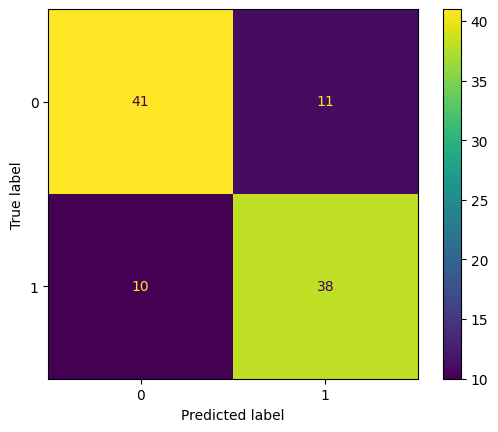

In [ ]:


disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()




In [ ]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_true, y_pred)

In [ ]:
accuracy

0.79